In [14]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import os
import matplotlib.pyplot as plt

In [15]:
def fetch_stock_data(symbol, start_date, end_date, api_key):
    # Define the API endpoint and parameters
    endpoint = "https://api.twelvedata.com/time_series"
    params = {
        "symbol": symbol,
        "start_date": start_date,
        "end_date": end_date,
        "interval": "1day",
        "apikey": api_key
    }

    try:
        # Send the HTTP request
        response = requests.get(endpoint, params=params)
        response.raise_for_status()  # Raise an exception for HTTP errors
        data = response.json()

        # Check if API returned an error message
        if 'error' in data:
            print("Error:", data['error'])
            return None

        return data['values']

    except requests.exceptions.RequestException as e:
        print("Error fetching data:", e)
        return None

def main():
    symbols = ["COIN", "BTC/USD", "ETH/USD"]  # Symbols for Coinbase, Bitcoin, and Ethereum
    start_date = "2013-01-01"  # Specify your start date
    end_date = "2024-04-01"    # Specify your end date
    api_key = os.getenv("TWELVE_DATA_API_KEY")

    # Create an empty DataFrame to store the data
    df = pd.DataFrame(columns=["Date"])

    for symbol in symbols:
        # Fetch stock data
        stock_data = fetch_stock_data(symbol, start_date, end_date, api_key)
        if stock_data:
            # Populate the DataFrame with fetched data
            symbol_data = []
            for data_point in stock_data:
                timestamp = datetime.fromisoformat(data_point['datetime'])
                close_price = data_point['close']
                symbol_data.append({"Date": timestamp, symbol: close_price})
            
            # Create DataFrame for the current symbol's data
            symbol_df = pd.DataFrame(symbol_data)
            
            # Merge with the main DataFrame on the common "Date" column
            df = pd.merge(df, symbol_df, on="Date", how="outer")

            # Print the symbol and length of DataFrame
            print(f"Symbol: {symbol}, Length of DataFrame: {len(df)}")

    # Sort DataFrame by date
    df.sort_values(by="Date", inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Remove rows with N/A values and set the Date as the index

    df.dropna(inplace=True)
    df.set_index("Date", inplace=True)

    # Return the DataFrame
    return df

In [16]:
# Call the main function and store the returned DataFrame
clean_data = main()

print("Number of rows in DataFrame:", len(clean_data))
print(clean_data.head())

Symbol: COIN, Length of DataFrame: 745
Symbol: BTC/USD, Length of DataFrame: 3303
Symbol: ETH/USD, Length of DataFrame: 3303
Number of rows in DataFrame: 640
                 COIN      BTC/USD     ETH/USD
Date                                          
2021-09-13  242.84000  44947.69141  3284.03003
2021-09-14  243.00000  47130.89844  3429.45996
2021-09-15  247.07001  48148.12109  3613.13989
2021-09-16  243.21001  47753.16016  3568.30005
2021-09-17  245.19000  47301.23047  3399.03003


In [17]:
final_data = clean_data.copy()
final_data = final_data.apply(pd.to_numeric)

# Display correlation matrix

correlation_matrix = final_data[['COIN', 'BTC/USD', 'ETH/USD']].corr()
print(correlation_matrix)

             COIN   BTC/USD   ETH/USD
COIN     1.000000  0.912992  0.960103
BTC/USD  0.912992  1.000000  0.929395
ETH/USD  0.960103  0.929395  1.000000


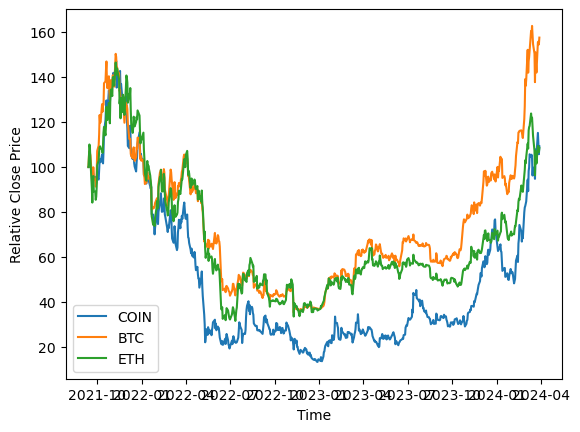

In [19]:
final_data['COIN_Relative_Close'] = final_data['COIN']/final_data['COIN'][0] * 100
final_data['BTC_Relative_Close'] = final_data['BTC/USD']/final_data['BTC/USD'][0] * 100
final_data['ETH_Relative_Close'] = final_data['ETH/USD']/final_data['ETH/USD'][0] * 100

plt.plot(final_data['COIN_Relative_Close'], label= 'COIN')
plt.plot(final_data['BTC_Relative_Close'], label= 'BTC')
plt.plot(final_data['ETH_Relative_Close'], label= 'ETH')
plt.xlabel('Time')
plt.ylabel('Relative Close Price')
plt.legend()
plt.show()

In [20]:
pairs = [('ETH/USD', 'BTC/USD'), ('ETH/USD', 'COIN'), ('BTC/USD', 'COIN')]

for pair in pairs:
    stock1, stock2 = pair
    spread = final_data[stock1] - final_data[stock2]
    mean_spread = spread.mean()
    std_spread = spread.std()
    entry_threshold = 1.5  # Adjust entry threshold as needed
    exit_threshold = 0.5   # Adjust exit threshold as needed
    
    # Enter long position if spread exceeds entry threshold
    buy_condition = spread > mean_spread + entry_threshold * std_spread
    final_data[f"{stock1}_Position"] = final_data[f"{stock1}_Position"].mask(buy_condition, "Buy")
    final_data[f"{stock2}_Position"] = final_data[f"{stock2}_Position"].mask(buy_condition, "Sell")

    # Exit long position if spread falls below exit threshold
    sell_condition = spread < mean_spread + exit_threshold * std_spread
    final_data[f"{stock1}_Position"] = final_data[f"{stock1}_Position"].mask(sell_condition, "Sell")
    final_data[f"{stock2}_Position"] = final_data[f"{stock2}_Position"].mask(sell_condition, "Buy")


print(final_data)

KeyError: 'ETH/USD_Position'